## Libraries

In [4]:
import requests
import pandas as pd

## Fetching Data

In [6]:
import pandas_datareader as pdr
endpoint_url = "https://financialmodelingprep.com/api/v3/historical-price-full/AAPL?apikey=wc2bbHWhFBL7no45kaUlx2xLHI2z2wv1"
response = requests.get(endpoint_url)
data = response.json()

## data preprocessing


In [10]:
# Convert data to DataFrame
df = pd.DataFrame(data["historical"])
df.to_csv('AAPL.csv')
# df.tail()




,date,open,high,low,close,adjClose,volume,unadjustedVolume,change,changePercent,vwap,label,changeOverTime
1253,2019-04-05,49.11,49.28,48.98,49.25,47.41,74106400,74106400,0.14,0.28507,49.17,"April 05, 19",0.002851
1254,2019-04-04,48.70,49.09,48.29,48.92,47.10,76457200,76457200,0.22,0.45175,48.77,"April 04, 19",0.004517
1255,2019-04-03,48.31,49.13,48.29,48.84,47.02,93087200,93087200,0.53,1.10000,48.75,"April 03, 19",0.011000
1256,2019-04-02,47.77,48.62,47.76,48.51,46.70,91062800,91062800,0.74,1.55000,48.29,"April 02, 19",0.015500
1257,2019-04-01,47.91,47.92,47.10,47.81,46.03,111448000,111448000,-0.10,-0.20872,47.61,"April 01, 19",-0.002087


## Feature selection



In [13]:
df1 = df.reset_index()['close']
df1




0       171.48
1       173.31
2       169.71
3       170.85
4       172.28
         ...  
1253     49.25
1254     48.92
1255     48.84
1256     48.51
1257     47.81
Name: close, Length: 1258, dtype: float64

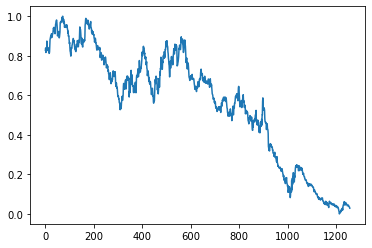

In [54]:
import matplotlib.pyplot as plt

plt.plot(df1)


In [19]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

## After transformation

In [20]:
df1

array([[0.82794935],
       [0.83977258],
       [0.81651376],
       ...,
       [0.03559891],
       [0.03346686],
       [0.02894431]])

## Training (65%) and Testing (35%) 

In [23]:
Training_size = int(len(df1)*0.65)
test_size = len(df1)-Training_size

train_data, test_data = df1[0:Training_size,:], df1[Training_size:len(df1),:1]

In [25]:
# Training_size,test_size


817

## Converting from array to  matrix dataset

In [26]:

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)    

In [30]:
# reshaping
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

## Time series Dataset

In [31]:
print(X_train.shape), print(y_train.shape)

(717, 100)
(717,)


(None, None)

In [32]:
# Reshape Input to be [samples, timesteps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1) # 1 at the end is for the 3d
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


## Creating / Building the LSTM Model

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [38]:
# stacked model
model = Sequential()
model.add(LSTM(50,return_sequences=True, input_shape =(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [39]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100, 50)           10400     
                                                                 
 lstm_4 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


# Training the model 

In [40]:
model.fit(X_train, y_train, validation_data=(X_test,y_test),epochs=100, batch_size=64, verbose=1)

Epoch 1/100
12/12 [==============================] - 8s 222ms/step - loss: 0.1627 - val_loss: 0.0163
Epoch 2/100
12/12 [==============================] - 1s 117ms/step - loss: 0.0172 - val_loss: 0.0380
Epoch 3/100
12/12 [==============================] - 1s 110ms/step - loss: 0.0080 - val_loss: 0.0193
Epoch 4/100
12/12 [==============================] - 1s 109ms/step - loss: 0.0052 - val_loss: 0.0267
Epoch 5/100
12/12 [==============================] - 1s 109ms/step - loss: 0.0039 - val_loss: 0.0211
Epoch 6/100
12/12 [==============================] - 1s 110ms/step - loss: 0.0036 - val_loss: 0.0157
Epoch 7/100
12/12 [==============================] - 1s 110ms/step - loss: 0.0034 - val_loss: 0.0140
Epoch 8/100
12/12 [==============================] - 1s 113ms/step - loss: 0.0030 - val_loss: 0.0124
Epoch 9/100
12/12 [==============================] - 1s 110ms/step - loss: 0.0028 - val_loss: 0.0091
Epoch 10/100
12/12 [==============================] - 1s 110ms/step - loss: 0.0025 - val_lo

## Prediction


In [41]:
import tensorflow as tf
tf.__version__

'2.9.1'

In [48]:
# prediction and checking performance
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

11/11 [==============================] - 0s 18ms/step


In [49]:
## transform back to original form 
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Calcualting RMSE performance metrics

In [50]:
import math 
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train, train_predict))


154.4125587154247

In [51]:
# test data RMSE
math.sqrt(mean_squared_error(y_test, test_predict))

72.18353186245888

# Plotting

In [61]:
print("Shape of test_predict:", train_predict.shape)
print("Length of test_predict:", len(train_predict))

print("Shape of test_predict:", test_predict.shape)
print("Length of test_predict:", len(test_predict))



Shape of test_predict: (717, 1)
Length of test_predict: 717
Shape of test_predict: (341, 1)
Length of test_predict: 341


In [68]:
look_back = 100


# change train predictions for plotting
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict


print("Length of test_predict:", len(test_predict))
print("Length of the slice:", len(trainPredictPlot[len(train_predict) + (look_back * 2) + 1:len(df1) - (look_back * 2), :]))

# change test predictions for plotting 

testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict) + (look_back * 2) + 1:len(train_predict) + (look_back * 2) + 1 + len(test_predict), :] = test_predict




print("Length of testPredictPlot slice:", len(trainPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :]))

plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(trainPredictPlot)

Length of test_predict: 341
Length of the slice: 140


ValueError: could not broadcast input array from shape (341,1) into shape (340,1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


ValueError: could not broadcast input array from shape (341,1) into shape (340,1)

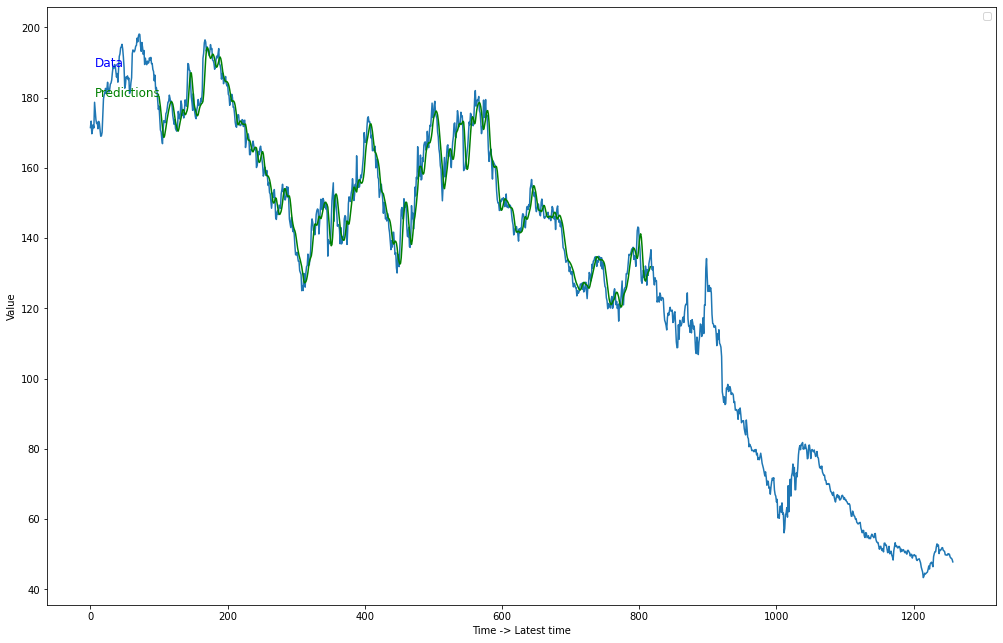

In [94]:
plt.figure(figsize=(17, 11))
plt.xlabel('Time -> Latest time')
plt.ylabel('Value')
plt.legend()

plt.text(0.05, 0.9, 'Data', color='blue', fontsize=12, transform=plt.gca().transAxes)
plt.text(0.05, 0.85, 'Predictions', color='green', fontsize=12, transform=plt.gca().transAxes)

# Plot the original data
plt.plot(scaler.inverse_transform(df1), label='Original Data', )

# Plot the training predictions
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
plt.plot(trainPredictPlot, label='Training Predictions', color="green")

# Plot the testing predictions
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict) + (look_back * 2) :len(df1), :] = test_predict

plt.plot(testPredictPlot, label='Testing Predictions',color="red")



plt.show()